In [1]:
from openai import OpenAI

from collections import Counter

from llmcoder.utils import get_openai_key, get_system_prompt

In [2]:
from bertopic import BERTopic
from tqdm import tqdm

In [3]:
client = OpenAI(api_key=get_openai_key())

In [4]:
code = """# General imports
import os

import pandas as pd
import numpy as np
import spacy
import matplotlib
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Custom imports
from tqdm import tqdm
from collections import Counter

# Ensure matplotlib works correctly with Jupyter
%matplotlib inline

df_characters = pd.read_csv('data/simpsons_characters.csv').reset_index(inplace=False, drop=True)
df_locations = pd.read_csv('data/simpsons_locations.csv').reset_index(inplace=False, drop=True)
df_script = pd.read_csv('data/simpsons_script_lines.csv').reset_index(inplace=False, drop=True)
df_episodes = pd.read_csv('data/simpsons_episodes.csv').reset_index(inplace=False, drop=True)

# """

In [5]:
messages = [{
    "role": "system",
    "content": get_system_prompt(),
}, {
    "role": "user",
    "content": code
}]

In [6]:
N_SAMPLES = 10_000

In [7]:
assert N_SAMPLES <= 10000  # Otherwise this will get very expensive

chat_completions = []

pbar = tqdm(total=N_SAMPLES)
while len(chat_completions) < N_SAMPLES:
    chat_completion = client.chat.completions.create(messages=messages, model='ft:gpt-3.5-turbo-1106:personal::8LCi9Q0d', n=min(128, N_SAMPLES - len(chat_completions)))
    chat_completions.extend(chat_completion.choices)
    pbar.update(len(chat_completion.choices))

100%|██████████| 10000/10000 [04:59<00:00, 32.01it/s]

100%|██████████| 10000/10000 [05:10<00:00, 32.01it/s]

In [10]:
answer_list = [choice.message.content for choice in chat_completions]

len(answer_list)

10000

In [8]:
import json

In [11]:
# Store the completions
with open('multi-choice-completions.json', 'w') as f:
    json.dump(answer_list, f, ensure_ascii=False, indent=4)

In [12]:
from sentence_transformers import SentenceTransformer
from umap import UMAP

In [13]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(answer_list, show_progress_bar=False)

In [14]:
from bertopic.representation import OpenAI

representation_model = OpenAI(client, model="gpt-3.5-turbo", delay_in_seconds=5, chat=True)

In [15]:
# Train BERTopic
topic_model = BERTopic(verbose=True, representation_model=representation_model).fit(answer_list, embeddings)

2023-12-08 09:26:52,073 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-08 09:27:11,133 - BERTopic - Dimensionality - Completed ✓
2023-12-08 09:27:11,134 - BERTopic - Cluster - Start clustering the reduced embeddings
2023-12-08 09:27:11,271 - BERTopic - Cluster - Completed ✓
2023-12-08 09:27:11,275 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 269/269 [27:02<00:00,  6.03s/it]
2023-12-08 09:54:13,810 - BERTopic - Representation - Completed ✓


In [60]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=1, metric='cosine').fit_transform(embeddings)

In [61]:
topic_representations = [topic_model.get_topic(topic_id) for topic_id in range(len(topic_model.get_topic_freq()))]

In [62]:
topic_model.set_topic_labels(topic_representations)

In [63]:
topic_model.visualize_documents(answer_list, reduced_embeddings=reduced_embeddings, width=1800, height=1000, hide_annotations=True, title="Next Thing After Importing Data:")

In [68]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("microsoft/CodeBERT-base")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/CodeBERT-base").to("cuda")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/CodeBERT-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
quality_scores = []
needs_comment_scores = []

for answer in tqdm(answer_list):
    full_code = code + answer

    # If the full_code is longer than 512 tokens, we need to truncate it
    while len(tokenizer.encode(full_code, return_tensors="pt")[0]) > 512:
        full_code = full_code[1:]

    input_ids = tokenizer.encode(full_code, return_tensors="pt").to(device)
    output = model(input_ids)
    quality_scores.append(output.logits[0, 0].to("cpu").tolist())
    needs_comment_scores.append(output.logits[0, 1].to("cpu").tolist())

input_ids = tokenizer.encode(code, return_tensors="pt").to(device)
quality_score_before = model(input_ids).logits[0, 0].cpu().tolist()
needs_comment_score_before = model(input_ids).logits[0, 1].cpu().tolist()

100%|██████████| 10000/10000 [01:08<00:00, 146.80it/s]


In [76]:
import matplotlib.pyplot as plt

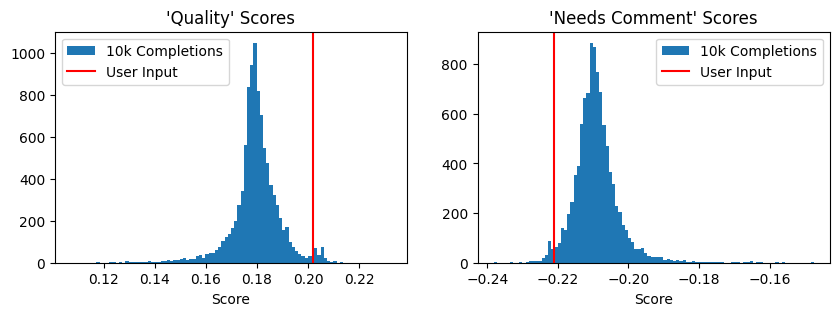

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(quality_scores, bins=100, label="10k Completions")
ax[0].set_title("'Quality' Scores")
ax[0].set_xlabel("Score")
ax[0].axvline(quality_score_before, color="red", label="User Input")
ax[0].legend()

ax[1].hist(needs_comment_scores, bins=100, label="10k Completions")
ax[1].set_title("'Needs Comment' Scores");
ax[1].set_xlabel("Score")
ax[1].axvline(needs_comment_score_before, color="red", label="User Input")
ax[1].legend();

In [88]:
# Show the best quality answers
best_quality_answers = sorted(zip(quality_scores, answer_list), reverse=True)
for quality, answer in best_quality_answers[:2]:
    print(f"Quality: {quality:.5f}\nAnswer: {answer}\n")

Quality: 0.23252
Answer: Define ordering of seasons and episodes
season_episode_order = {
    (1, 1): 1,   (1, 2): 2,   (1, 3): 3,   (1, 4): 4,
    (2, 1): 5,   (2, 2): 6,   (2, 3): 7,   (2, 4): 8,
    (3, 1): 9,   (3, 2): 10,  (3, 3): 11,  (3, 4): 12,
    (4, 1): 13,  (4, 2): 14,  (4, 3): 15,  (4, 4): 16,
    (5, 1): 17,  (5, 2): 18,  (5, 3): 19,  (5, 4): 20,
    (6, 1): 21,  (6, 2): 22,  (6, 3): 23,  (6, 4): 24,
    (7, 1): 25,  (7, 2): 26,  (7, 3): 27,  (7, 4): 28,
    (8, 1): 29,  (8, 2): 30,  (8, 3): 31,  (8, 4): 32,
    (9, 1): 33,  (9, 2): 34,  (9, 3): 35,  (9, 4): 36,
    (10, 1): 37, (10, 2): 38, (10, 3): 39, (10, 4): 40,
    (11, 1): 41, (11, 2): 42, (11, 3): 43, (11, 4): 44,
    (12, 1): 45, (12, 2): 46, (12, 3): 47, (12, 4): 48,
    (13, 1): 49, (13, 2): 50, (13, 3): 51, (13, 4): 52,
    (14, 1): 53, (14, 2): 54, (14, 3): 55, (14, 4): 56,
    (15, 1): 57, (15, 2): 58, (15, 3): 59, (15, 4): 60,
    (16, 1): 61, (16, 2): 62, (16, 3): 63, (16, 4): 64,
    (17, 1): 65, (17, 2):

In [89]:
# Show the worst quality answers
worst_quality_answers = sorted(zip(quality_scores, answer_list), reverse=False)
for quality, answer in worst_quality_answers[:2]:
    print(f"Quality: {quality:.5f}\nAnswer: {answer}\n")

Quality: 0.10720
Answer:  Set text cleaning settings
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

# Constants
white_list_chars = [
    "bart", "homer", "marge", "maggie", "lisa", "krusty", "burns",
    "millhouse", "apu", "moe", "ned", "edna", "skinner", "ralph",
    "barney", "todd", "rod", "hans", "troy", "citizen", "abraham",
    "lenny", "carl", "lionel", "selma", "patty", "milhouse", "montgomery",
    "clancy", "waylon", "apu_nahasapeemapetilon"
]

# Function to preprocess texts
def clean_text(text: str) -> str:
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation, digits and special characters
    text = " ".join(token.lemma_ for token in nlp(text) if token.is_alpha)
    
    return text

Quality: 0.11111
Answer: def preprocess_dialogue(dialogue):
    """
    Function to preprocess dialogue text data
    
    Args:
    dialogue - A string containing the dialogue
    
    Returns:
    clean_dialogue - The preprocessed and cleaned dialo

In [104]:
import numpy as np

In [103]:
topic_quality_scores = {id: [] for id in topic_model.topics_}
topic_needs_comment_scores = {id: [] for id in topic_model.topics_}

for answer, quality_score, needs_comment_score, id in zip(answer_list, quality_scores, needs_comment_scores, topic_model.topics_):
    topic_quality_scores[id].append(quality_score)
    topic_needs_comment_scores[id].append(needs_comment_score)

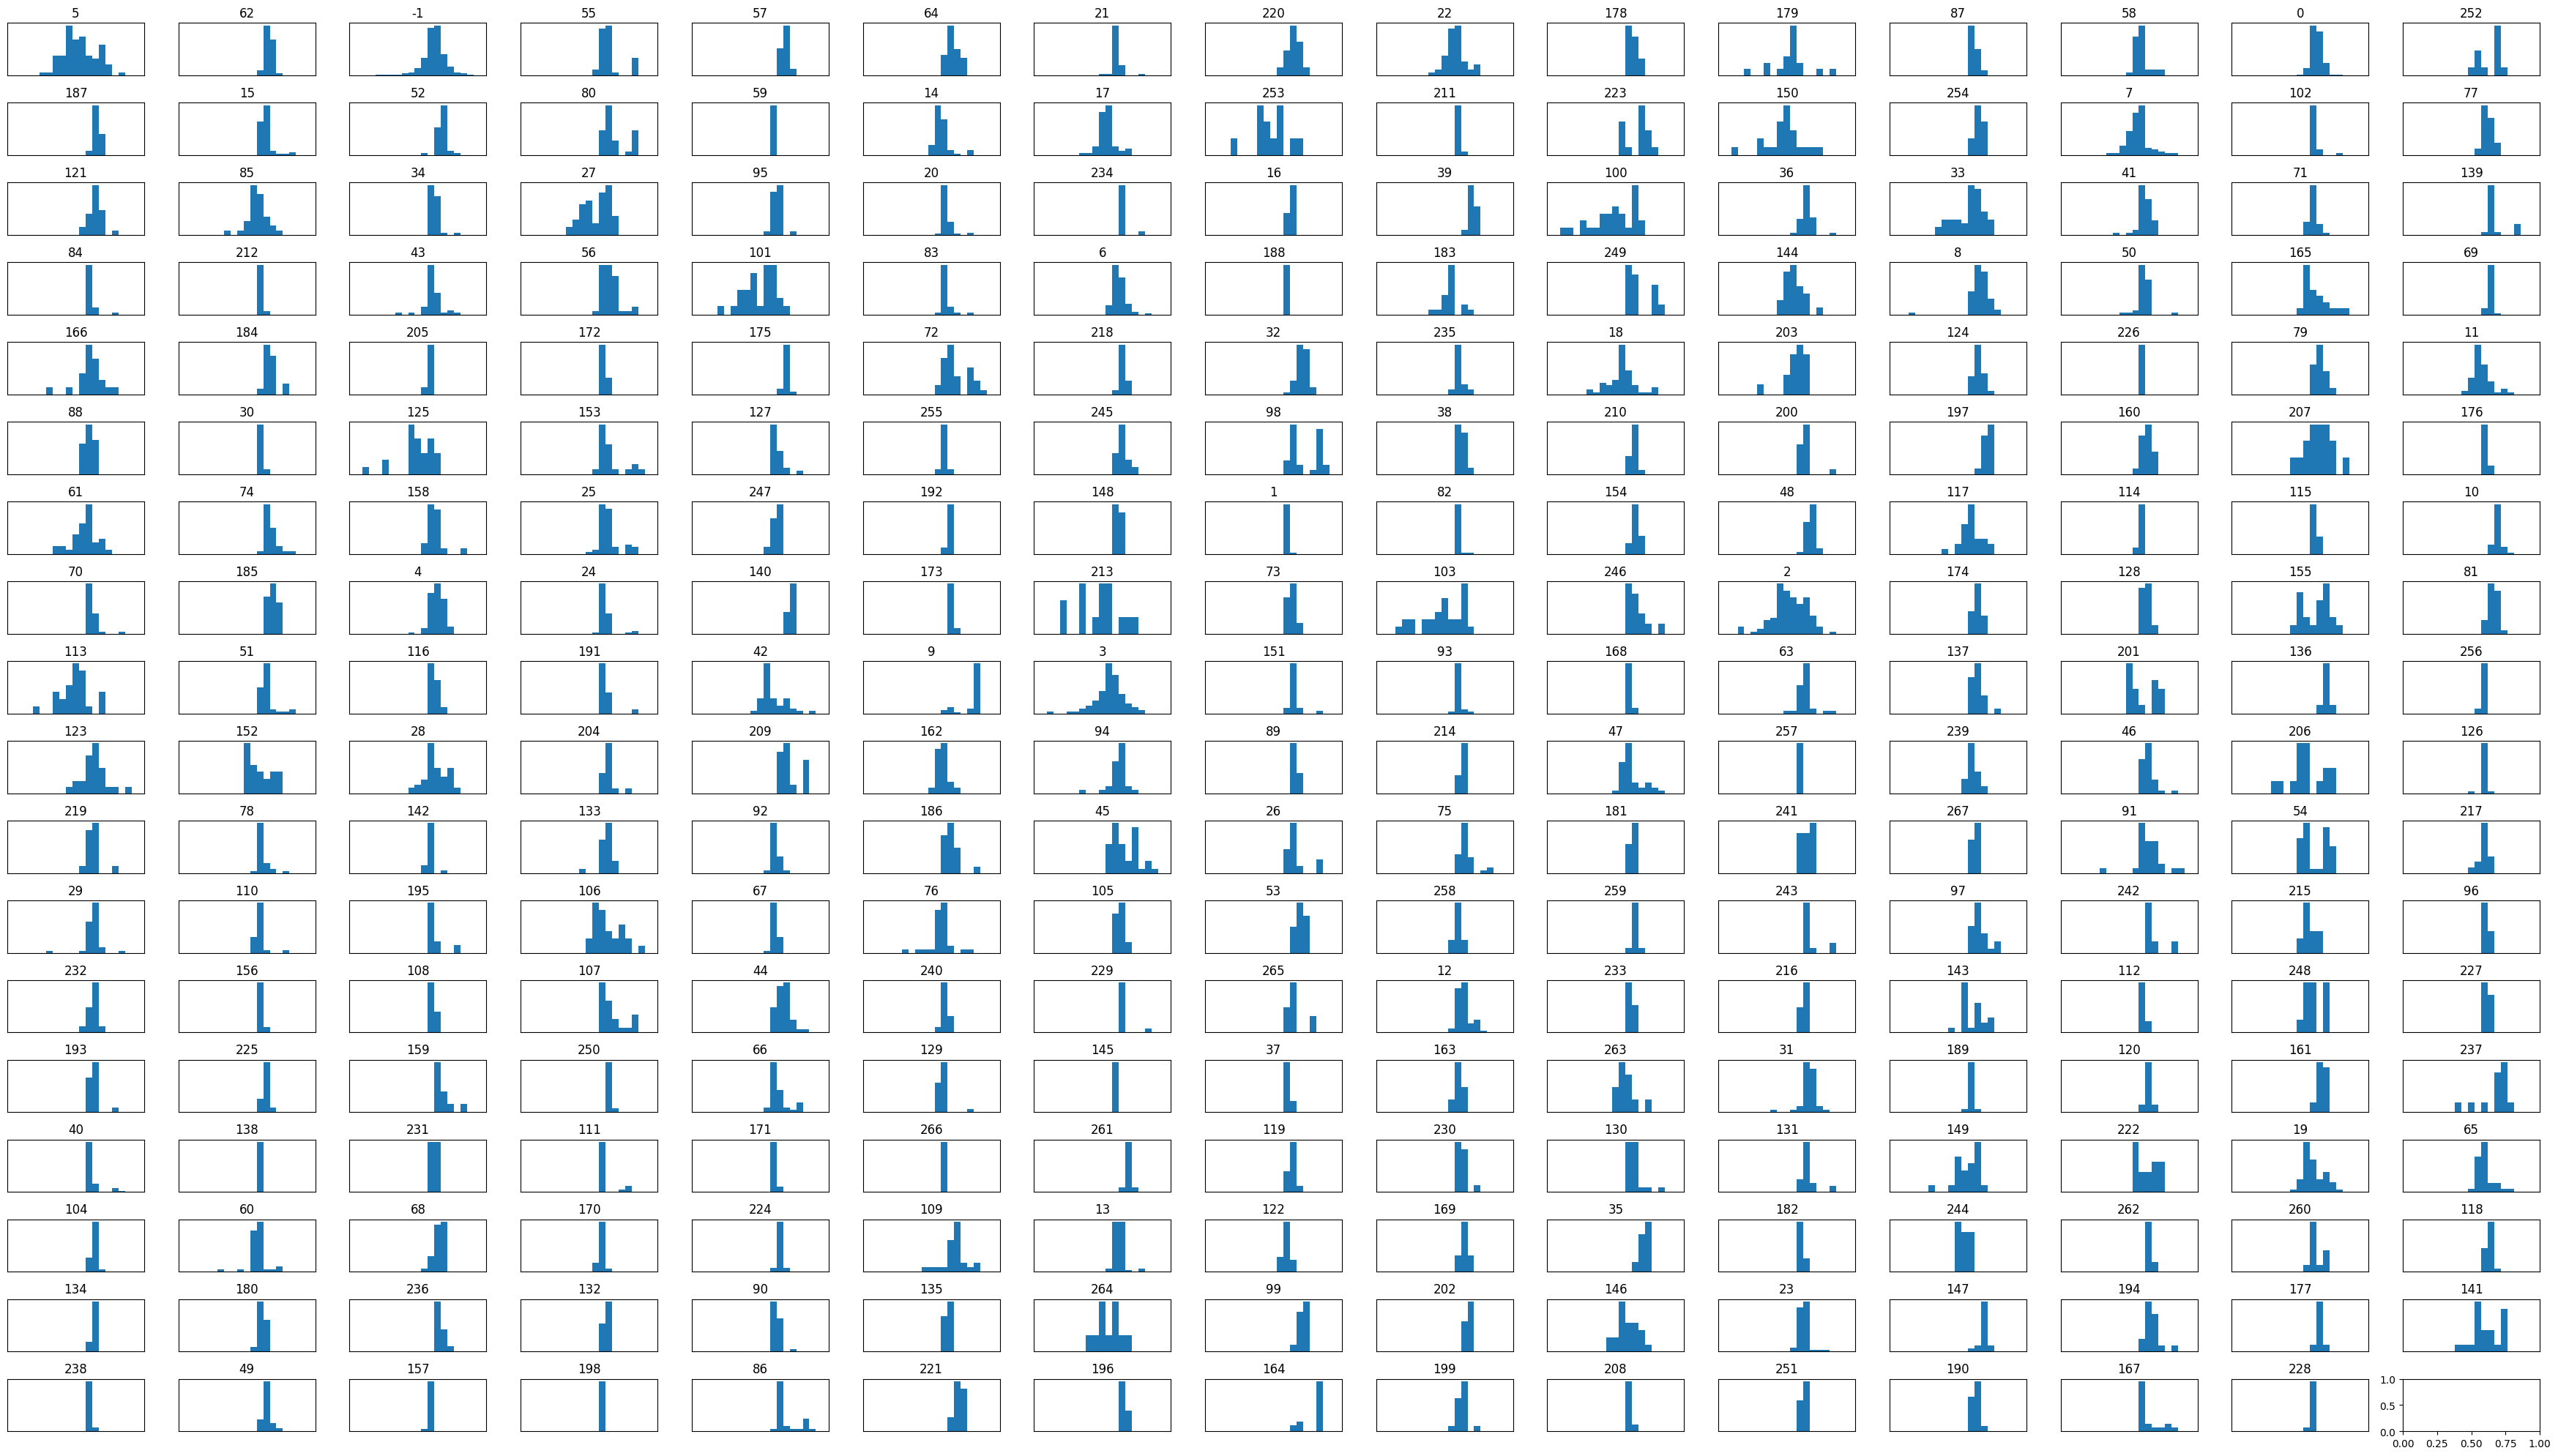

In [110]:
# Show the distribution of scores for all topics
n_topics = len(np.unique(topic_model.topics_))

N_COLS = 15
N_ROWS = int(np.ceil(n_topics / N_COLS))

fig, ax = plt.subplots(N_ROWS, N_COLS, figsize=(35, 20))

bins = np.linspace(0.11, 0.22, 20)

for i, (topic_id, quality_scores) in enumerate(topic_quality_scores.items()):
    ax[i // N_COLS, i % N_COLS].hist(quality_scores, bins=bins)
    ax[i // N_COLS, i % N_COLS].set_title(f"{topic_id}")
    ax[i // N_COLS, i % N_COLS].set_yticks([])
    ax[i // N_COLS, i % N_COLS].set_xticks([])

fig.tight_layout()

In [114]:
# Compute the mean and std score for each topic
topic_quality_scores_mean = {id: np.mean(scores) for id, scores in topic_quality_scores.items()}
topic_quality_scores_std = {id: np.std(scores) for id, scores in topic_quality_scores.items()}

# Sort the topics by their id
sorted_topic_quality_scores_mean = sorted(topic_quality_scores_mean.items(), key=lambda x: x[0])
sorted_topic_quality_scores_std = sorted(topic_quality_scores_std.items(), key=lambda x: x[0])

In [141]:
# Get the size of each topic
topic_sizes = Counter(topic_model.topics_)

In [142]:
topic_sizes = {id: size for id, size in sorted(topic_sizes.items(), key=lambda x: x[0])}

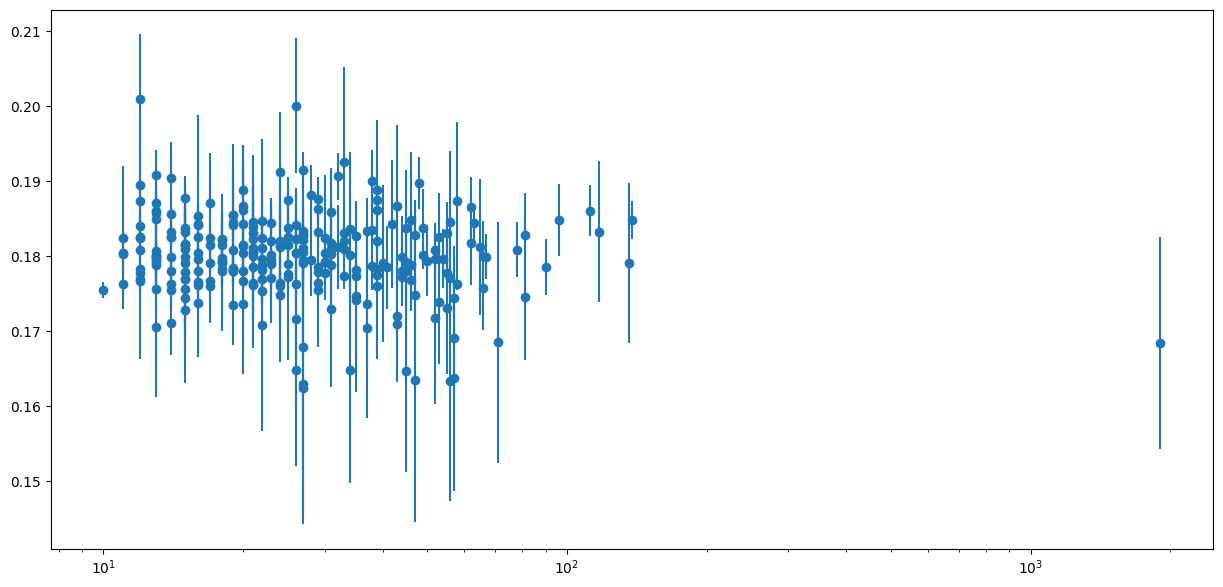

In [143]:
# Plot an errorbar plot for each topic
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.errorbar(list(topic_sizes.values()), list(topic_quality_scores_mean.values()), yerr=list(topic_quality_scores_std.values()), fmt='o')
ax.set_xscale('log')

In [148]:
import pandas as pd

In [150]:
# for id, _ in sorted(topic_quality_scores_mean.items(), key=lambda x: x[1], reverse=True):
#     print(f"Topic {id}: {topic_model.get_topic(id)}, size: {topic_sizes[id]}, mean: {topic_quality_scores_mean[id]:.5f}, std: {topic_quality_scores_std[id]:.5f}")

# Create a dataframe with the topic id, name, size, mean score, and std score
score_df = pd.DataFrame({
    "id": [id for id, _ in sorted_topic_quality_scores_mean],
    "name": [topic_model.get_topic(id) for id, _ in sorted_topic_quality_scores_mean],
    "size": [topic_sizes[id] for id, _ in sorted_topic_quality_scores_mean],
    "mean": [mean for _, mean in sorted_topic_quality_scores_mean],
    "std": [std for _, std in sorted_topic_quality_scores_std],
})

In [152]:
# Save the dataframe to a csv file
score_df.to_csv("topic_scores.csv", index=False)